# 🧪 Classic Super-Resolution Techniques
This notebook presents practical implementations of five classical super-resolution techniques:
1. Bilinear, Bicubic, Area and Lanczos interpolation
2. Iterative Back-Projection (IBP)
3. Non-Local Means Super-Resolution
4. Edge-Guided Interpolation (EGI)
5. Frequency Domain Extrapolation

In [1]:
import os
import sys
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

from SRModels.classic_super_resolution_algorithms.profiling_methods import *
from SRModels.classic_super_resolution_algorithms.classic_algorithms import *
from SRModels.classic_super_resolution_algorithms.visualization_methods import *

## Tracking structures for profiling data

In [2]:
algorithms = ['bilinear','bicubic','area','lanczos','ibp','nlm','egi','freq']

time_stats = {
    'bilinear': [], 'bicubic': [], 'area': [], 'lanczos': [],
    'ibp': [], 'nlm': [], 'egi': [], 'freq': []
}
memory_stats = {k: [] for k in time_stats}
psnr_stats = {k: [] for k in time_stats}
ssim_stats = {k: [] for k in time_stats}
mae_stats = {k: [] for k in time_stats}
rmse_stats = {k: [] for k in time_stats}
throughput_stats = {k: [] for k in time_stats}  # MP/s per image (aún sin poblar)
gradient_mse_stats = {k: [] for k in time_stats}
epi_stats = {k: [] for k in time_stats}
hf_energy_ratio_stats = {k: [] for k in time_stats}
kl_luma_stats = {k: [] for k in time_stats}
kl_color_stats = {k: [] for k in time_stats}

# Time & Memory jitter / variance
time_jitter = {}
time_variance = {}
mem_variance = {}

HF_RADIUS_FRACTION = 0.6  # threshold for high-frequency mask
EPS_NUM = 1e-9

example_index = 0
vis = None         
ibp_example = None 
nlm_example = None 
egi_example = None 
freq_example = None

# Plot colors
colors = {
    'bilinear': '#4c72b0',
    'bicubic':  '#55a868',
    'area':     '#c44e52',
    'lanczos':  '#8172b2',
    'ibp':      '#ccb974',
    'nlm':      '#64b5cd',
    'egi':      '#8c8c8c',
    'freq':     '#937860',
}

# Directory for saving result figures
RESULTS_DIR = Path('classic_algorithms_results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

## Loading dataset

In [3]:
HR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR/low_z_offset"))
LR_DIR = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR/low_z_offset"))

hr_paths = sorted(glob.glob(os.path.join(HR_DIR, '*.png')))
lr_paths = sorted(glob.glob(os.path.join(LR_DIR, '*.png')))

assert len(hr_paths) == len(lr_paths) and len(hr_paths) > 0, "No HR/LR pairs found or the number does not match"

# Load all images into memory (if possible); otherwise, process in streaming
hr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in hr_paths]
lr_images = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in lr_paths]

## Main Loop

In [4]:
for idx, (hr_img, lr_img) in enumerate(zip(hr_images, lr_images)):
    # -------------------- #
    # INTERPOLATION FAMILY #
    # -------------------- #
    h, w = hr_img.shape[:2]

    # Bilinear
    def _bilinear():
        return interpolate_bilinear(lr_img, (w, h))
    bilinear, bilinear_time = time_algorithm(_bilinear)
    _, bilinear_mem = memory_algorithm(_bilinear)
    time_stats['bilinear'].append(bilinear_time)
    memory_stats['bilinear'].append(bilinear_mem)

    # Bicubic
    def _bicubic():
        return interpolate_bicubic(lr_img, (w, h))
    bicubic, bicubic_time = time_algorithm(_bicubic)
    _, bicubic_mem = memory_algorithm(_bicubic)
    time_stats['bicubic'].append(bicubic_time)
    memory_stats['bicubic'].append(bicubic_mem)

    # Area
    def _area():
        return interpolate_area(lr_img, (w, h))
    area, area_time = time_algorithm(_area)
    _, area_mem = memory_algorithm(_area)
    time_stats['area'].append(area_time)
    memory_stats['area'].append(area_mem)

    # Lanczos
    def _lanczos():
        return interpolate_lanczos(lr_img, (w, h))
    lanczos, lanczos_time = time_algorithm(_lanczos)
    _, lanczos_mem = memory_algorithm(_lanczos)
    time_stats['lanczos'].append(lanczos_time)
    memory_stats['lanczos'].append(lanczos_mem)

    # Metrics (color) for interpolation outputs
    hr_f = hr_img.astype(np.float32) / 255.0
    for name, sr_img in [("bilinear", bilinear), ("bicubic", bicubic), ("area", area), ("lanczos", lanczos)]:
        sr_f = sr_img.astype(np.float32) / 255.0
        psnr_stats[name].append(psnr(hr_f, sr_f, data_range=1.0))
        ssim_stats[name].append(ssim(hr_f, sr_f, channel_axis=2, data_range=1.0))
        # Extended metrics (color)
        mae_stats[name].append(mae(hr_img, sr_img))
        rmse_stats[name].append(rmse(hr_img, sr_img))
        gradient_mse_stats[name].append(gradient_mse(hr_img, sr_img))
        epi_stats[name].append(epi(hr_img, sr_img))
        hf_energy_ratio_stats[name].append(
            hf_energy_ratio(cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
                            cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY),
                            radius_frac=HF_RADIUS_FRACTION)
        )
        kl_luma_stats[name].append(
            kl_divergence(cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY),
                          cv2.cvtColor(sr_img, cv2.COLOR_RGB2GRAY))
        )
        kl_color_stats[name].append(kl_divergence_color(hr_img, sr_img))

    # ---------------- #
    # ADVANCED METHODS #
    # ---------------- #
    hr_g = cv2.cvtColor(hr_img, cv2.COLOR_RGB2GRAY)
    lr_g = cv2.cvtColor(lr_img, cv2.COLOR_RGB2GRAY)

    # IBP
    def ibp_run():
        return back_projection(hr_g, lr_g, iterations=10)
    ibp_res, ibp_time = time_algorithm(ibp_run)
    _, ibp_mem = memory_algorithm(ibp_run)
    time_stats['ibp'].append(ibp_time)
    memory_stats['ibp'].append(ibp_mem)

    # NLM
    def nlm_run():
        return non_local_means(hr_g, lr_g)
    nlm_res, nlm_time = time_algorithm(nlm_run)
    _, nlm_mem = memory_algorithm(nlm_run)
    time_stats['nlm'].append(nlm_time)
    memory_stats['nlm'].append(nlm_mem)

    # EGI
    def egi_run():
        return edge_guided_interpolation(hr_g, lr_g)
    egi_res, egi_time = time_algorithm(egi_run)
    _, egi_mem = memory_algorithm(egi_run)
    time_stats['egi'].append(egi_time)
    memory_stats['egi'].append(egi_mem)

    # Frequency domain extrapolation
    def freq_run():
        return frequency_extrapolation(hr_g, lr_g)
    freq_res, freq_time = time_algorithm(freq_run)
    _, freq_mem = memory_algorithm(freq_run)
    time_stats['freq'].append(freq_time)
    memory_stats['freq'].append(freq_mem)

    if np.max(freq_res) > 0:
        freq_up_uint8 = (freq_res / np.max(freq_res) * 255.0).astype(np.uint8)
    else:
        freq_up_uint8 = freq_res.astype(np.uint8)

    # Metrics (grayscale) for advanced outputs
    data_range_nlm = hr_g.max() - hr_g.min() if hr_g.max() != hr_g.min() else 255.0
    for name, sr_g in [('ibp', ibp_res), ('nlm', nlm_res), ('egi', egi_res), ('freq', freq_up_uint8)]:
        dr = data_range_nlm if name == 'nlm' else 255.0
        psnr_stats[name].append(psnr(hr_g, sr_g, data_range=dr))
        ssim_stats[name].append(ssim(hr_g, sr_g, data_range=dr))
        mae_stats[name].append(mae(hr_g, sr_g))
        rmse_stats[name].append(rmse(hr_g, sr_g))
        gradient_mse_stats[name].append(gradient_mse(hr_g, sr_g))
        epi_stats[name].append(epi(hr_g, sr_g))
        hf_energy_ratio_stats[name].append(hf_energy_ratio(hr_g, sr_g, radius_frac=HF_RADIUS_FRACTION))
        kl_luma_stats[name].append(kl_divergence(hr_g, sr_g))
        kl_color_stats[name].append(np.nan)  # Not applicable for grayscale

    # Store example artifacts once (chosen by example_index)
    if idx == example_index:
        vis = (hr_img, lr_img, bilinear, bicubic, area, lanczos)
        ibp_example = (hr_g, lr_g, ibp_res)
        nlm_example = (hr_g, nlm_res)
        egi_example = (hr_g, lr_g, egi_res)
        freq_example = (hr_g, freq_up_uint8)

In [ ]:
def build_metrics_summary():
    """
    Build aggregated per-algorithm summary metrics from global stats dictionaries.
    Returns a dict keyed by algorithm with mean/max/var and other derived fields.
    Also updates global time_jitter, time_variance, mem_variance for reference.
    """
    
    # Compute time/memory jitter & variance from collected stats
    tj, tv, mv = {}, {}, {}
    for alg in time_stats.keys():
        t_arr = time_stats.get(alg, [])
        if len(t_arr) > 1 and np.mean(t_arr) > 0:
            tj[alg] = float(np.std(t_arr, ddof=1) / np.mean(t_arr))
            tv[alg] = float(np.var(t_arr, ddof=1))
        else:
            tj[alg] = np.nan
            tv[alg] = np.nan

        m_arr = memory_stats.get(alg, [])
        if len(m_arr) > 1:
            mv[alg] = float(np.var(m_arr, ddof=1))
        else:
            mv[alg] = np.nan

    # Update globals
    time_jitter = tj
    time_variance = tv
    mem_variance = mv

    # Confidence intervals for PSNR/SSIM
    psnr_ci = {alg: bootstrap_ci(vals) for alg, vals in psnr_stats.items()}
    ssim_ci = {alg: bootstrap_ci(vals) for alg, vals in ssim_stats.items()}

    # Aggregate statistics per algorithm
    summary = {}
    for alg in time_stats.keys():
        time_stats_alg = compute_summary_stats(time_stats.get(alg, []))
        mem_stats_alg = compute_summary_stats(memory_stats.get(alg, []))
        psnr_stats_alg = compute_summary_stats(psnr_stats.get(alg, []))
        ssim_stats_alg = compute_summary_stats(ssim_stats.get(alg, []))
        mae_stats_alg = compute_summary_stats(mae_stats.get(alg, []))
        rmse_stats_alg = compute_summary_stats(rmse_stats.get(alg, []))
        grad_stats_alg = compute_summary_stats(gradient_mse_stats.get(alg, []))
        epi_stats_alg = compute_summary_stats(epi_stats.get(alg, []))
        hf_stats_alg = compute_summary_stats(hf_energy_ratio_stats.get(alg, []))
        kl_luma_stats_alg = compute_summary_stats(kl_luma_stats.get(alg, []))
        kl_color_stats_alg = compute_summary_stats(kl_color_stats.get(alg, []))

        summary[alg] = {
            'psnr_mean': psnr_stats_alg['mean'],
            'psnr_var': psnr_stats_alg['var'],
            'psnr_max': psnr_stats_alg['max'],
            'psnr_ci_low': psnr_ci[alg][0],
            'psnr_ci_high': psnr_ci[alg][1],
            'ssim_mean': ssim_stats_alg['mean'],
            'ssim_var': ssim_stats_alg['var'],
            'ssim_max': ssim_stats_alg['max'],
            'ssim_ci_low': ssim_ci[alg][0],
            'ssim_ci_high': ssim_ci[alg][1],
            'time_mean': time_stats_alg['mean'],
            'time_max': time_stats_alg['max'],
            'time_jitter': time_jitter[alg],
            'time_var': time_variance[alg],
            'memory_mean': mem_stats_alg['mean'],
            'memory_max': mem_stats_alg['max'],
            'memory_var': mem_variance[alg],
            'mae_mean': mae_stats_alg['mean'],
            'mae_max': mae_stats_alg['max'],
            'rmse_mean': rmse_stats_alg['mean'],
            'rmse_max': rmse_stats_alg['max'],
            'grad_mse_mean': grad_stats_alg['mean'],
            'epi_mean': epi_stats_alg['mean'],
            'hf_ratio_mean': hf_stats_alg['mean'],
            'kl_luma_mean': kl_luma_stats_alg['mean'],
            'kl_color_mean': kl_color_stats_alg['mean'],
        }
    return summary

# Build the summary using collected stats
metric_summary = build_metrics_summary()

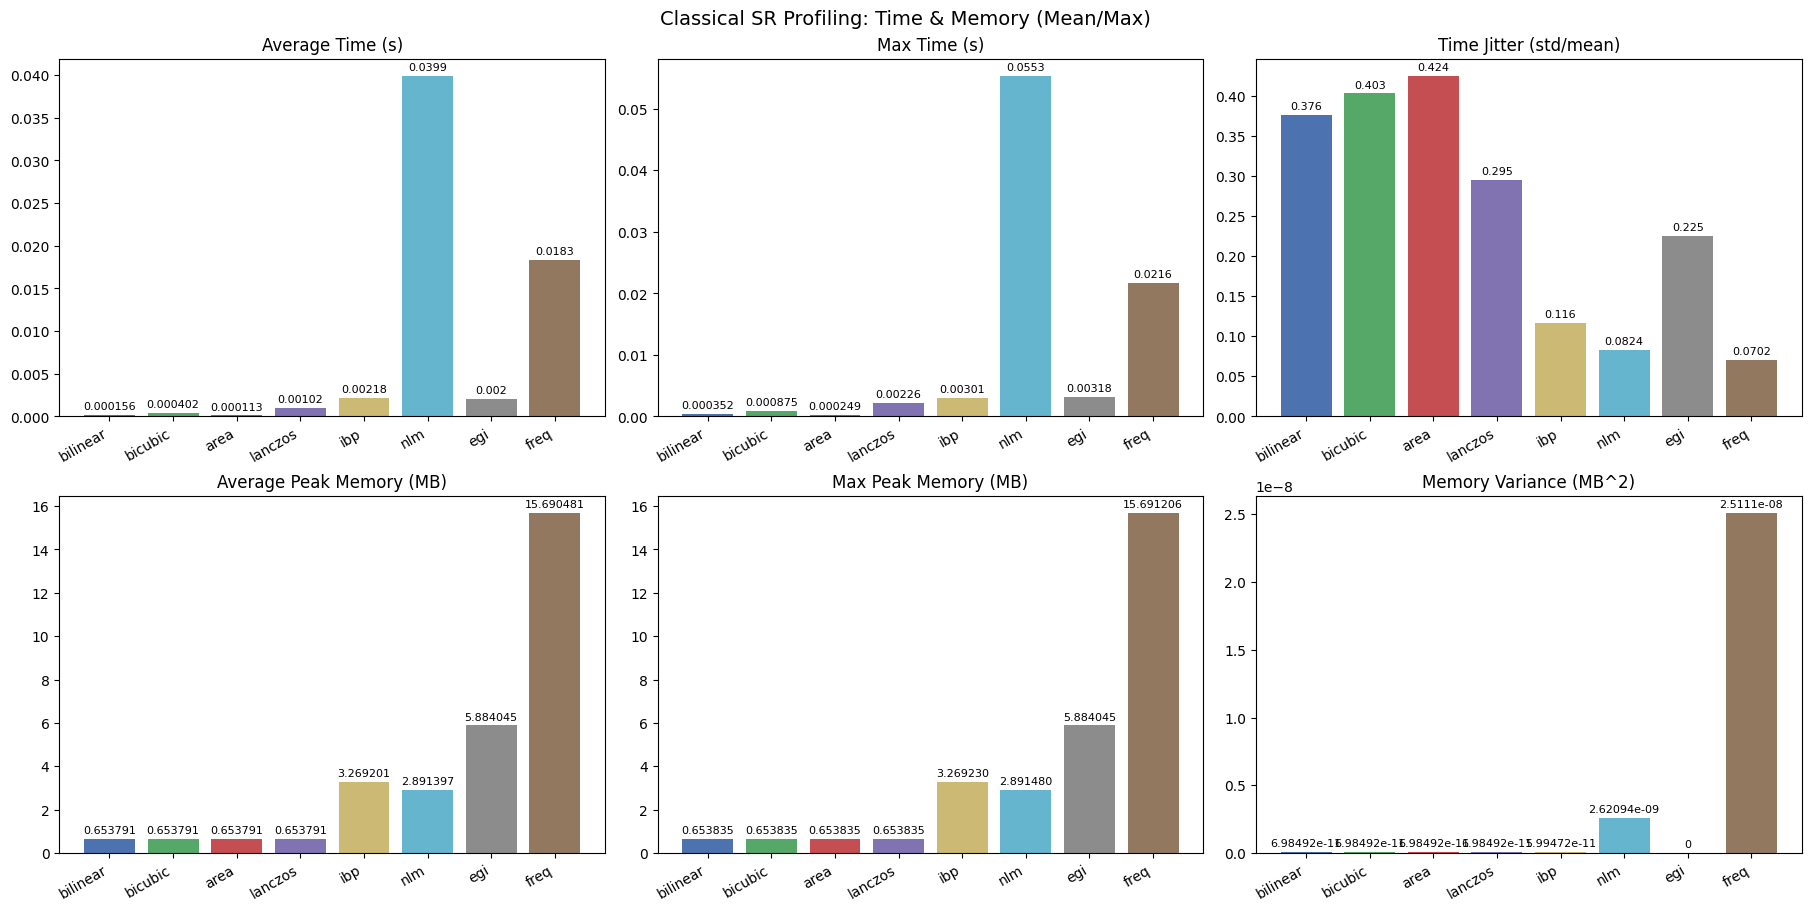

In [6]:
plot_time_memory_panels(
    metric_summary=metric_summary,
    algorithms_order=algorithms,
    colors_map=colors,
    main_title='Classical SR Profiling: Time & Memory (Mean/Max)',
    outfile=RESULTS_DIR / 'time_memory_summary.png',
    figsize=(18, 9)
)

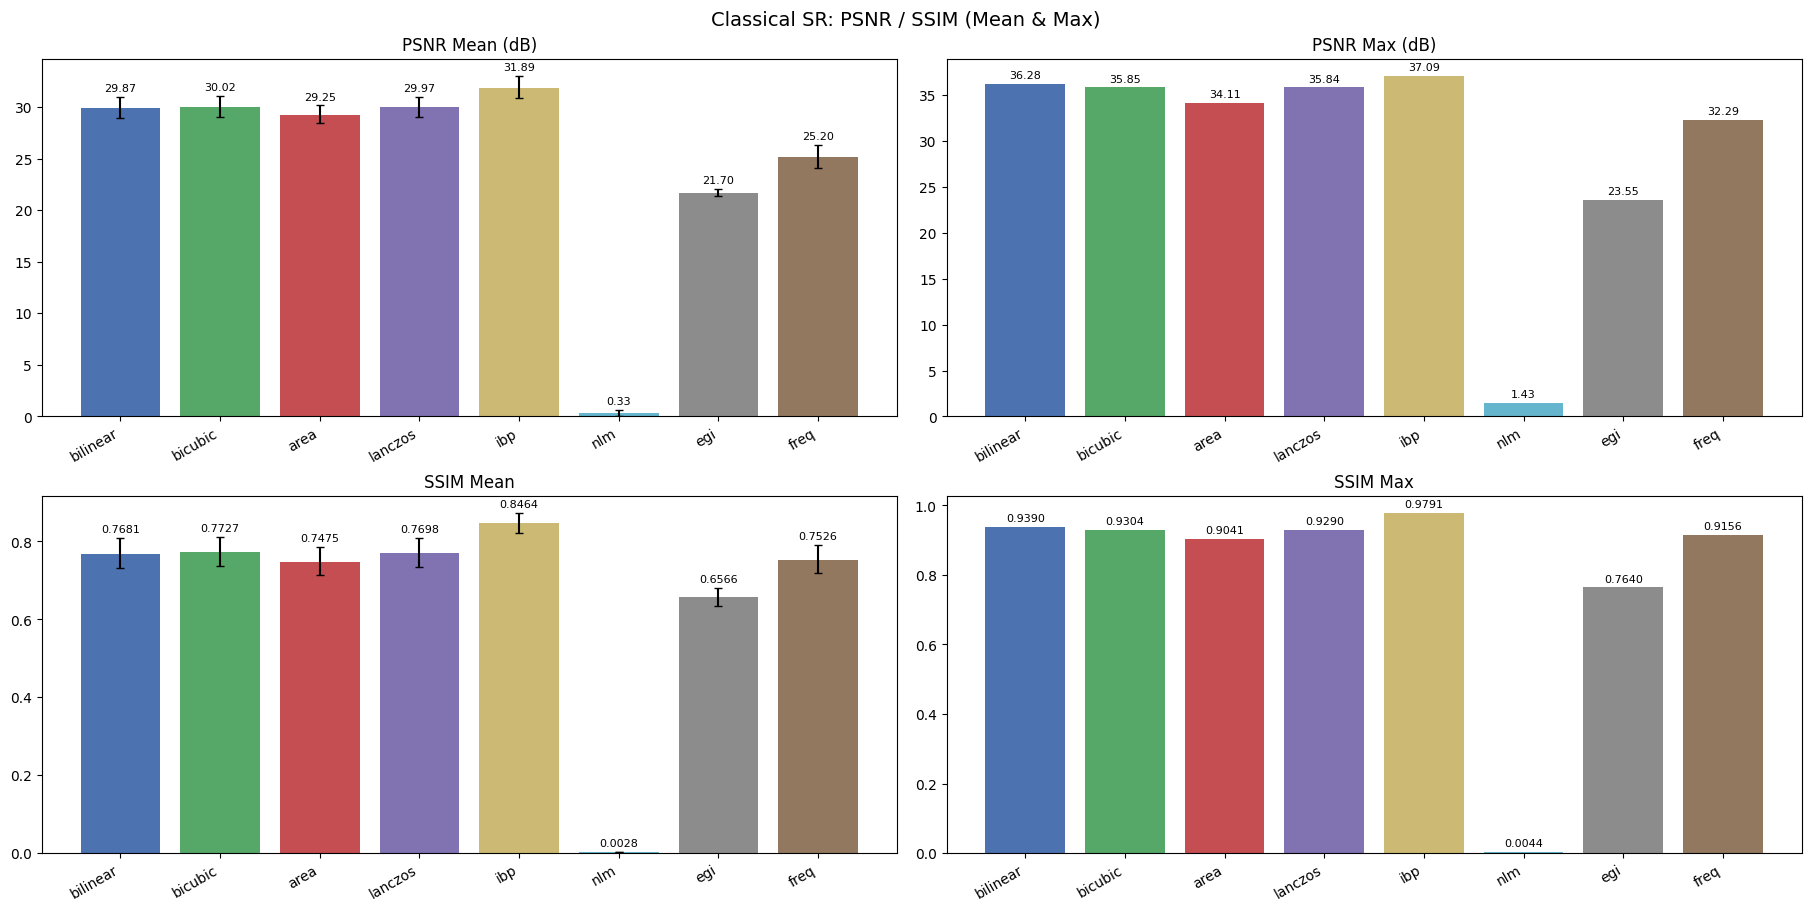

In [7]:
plot_psnr_ssim_panels(
    metric_summary=metric_summary,
    algorithms_order=algorithms,
    colors_map=colors,
    main_title='Classical SR: PSNR / SSIM (Mean & Max)',
    outfile=RESULTS_DIR / 'psnr_ssim_summary.png',
    figsize=(18, 9)
)

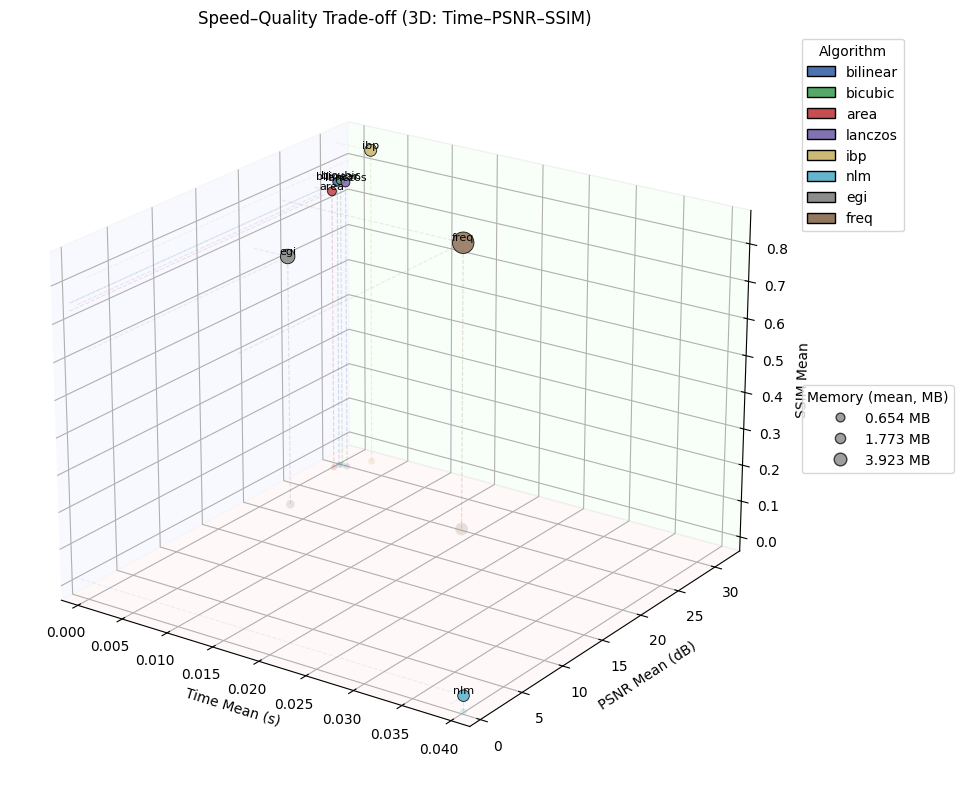

In [8]:
plot_speed_quality_tradeoff_3d(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    save=True,
    figsize=(10, 8),
    view=(22, -55),
)

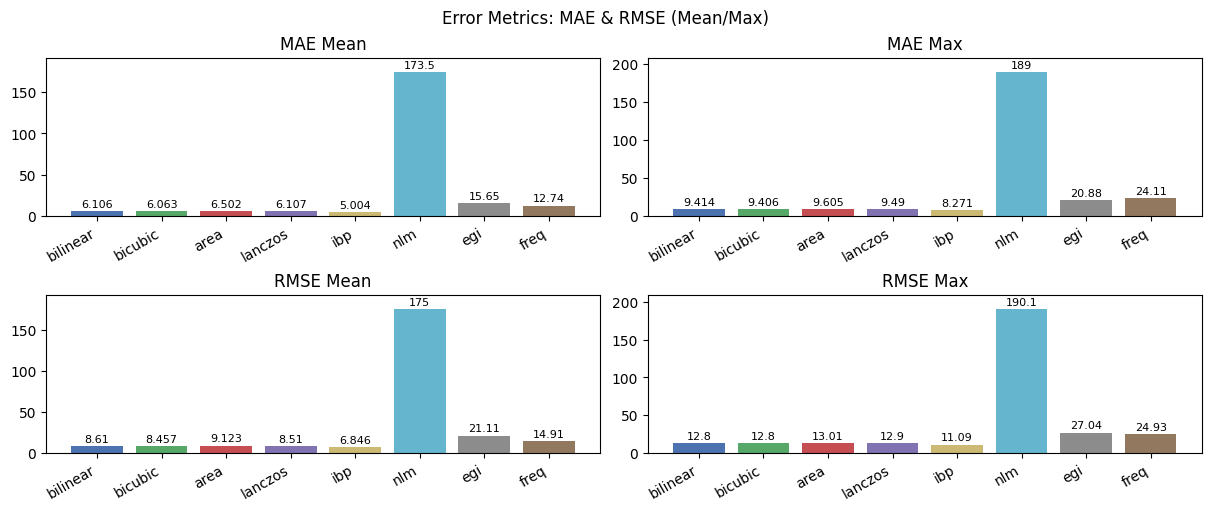

In [11]:
plot_error_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(12, 5),
)

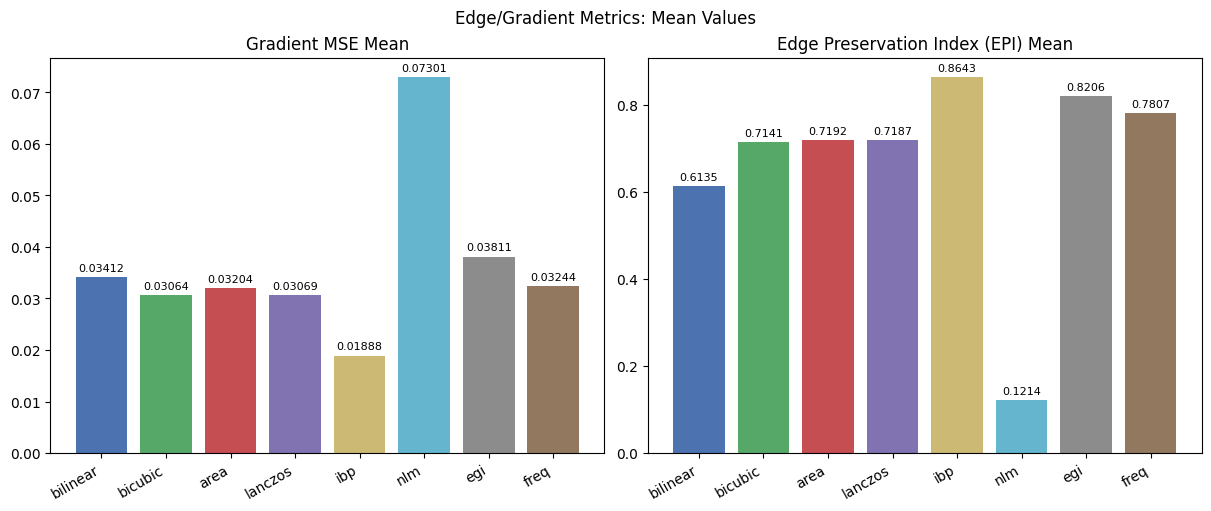

In [12]:
plot_edge_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(12, 5)
)

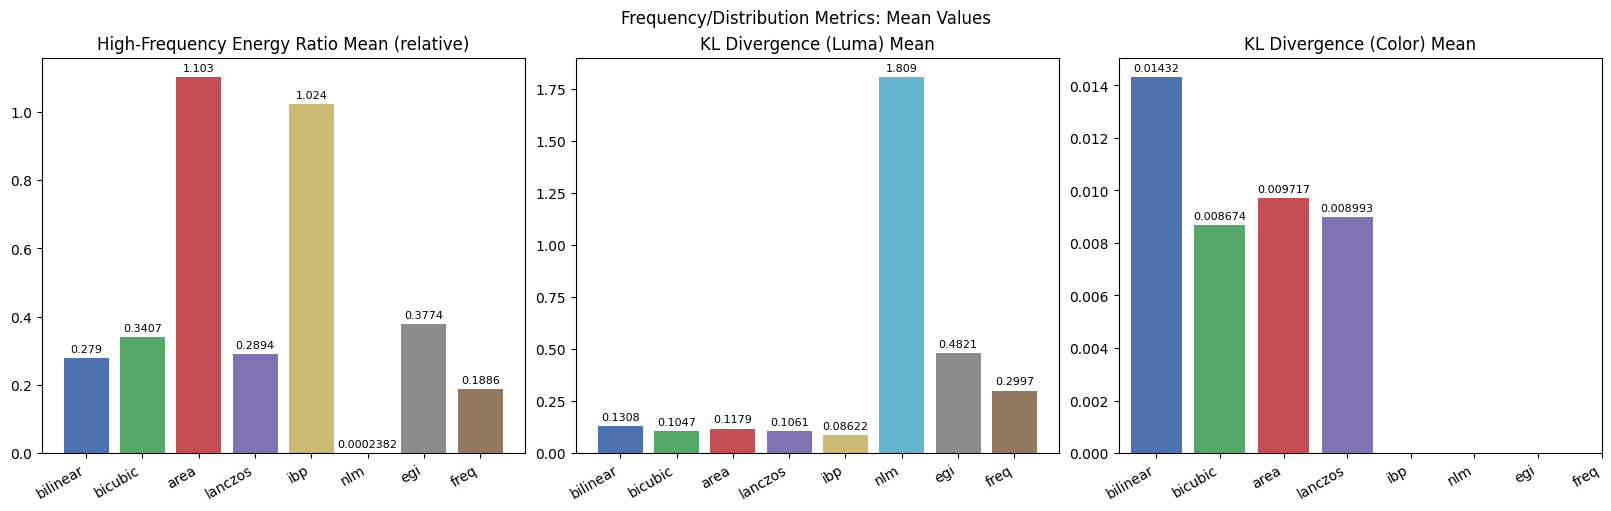

In [13]:
plot_frequency_distribution_metrics_grid(
    metric_summary=metric_summary,
    algorithms=algorithms,
    colors=colors,
    results_dir=RESULTS_DIR,
    figsize=(16, 5)
)

In [ ]:
plot_and_save_super_resolution_example(vis, ibp_example, nlm_example, egi_example, freq_example, RESULTS_DIR)

In [ ]:
plot_and_save_ssim_similarity_maps(vis, ibp_example, nlm_example, egi_example, freq_example, RESULTS_DIR)

In [14]:
def show_algorithm_ranking(metric_summary, maximize=None, minimize=None, weights=None):
    """
    Compute and display ranking using rank_algorithms(summary, maximize, minimize, weights).

    Prints the ranked list and returns it along with raw scores and bounds.
    """
    ranked, scores, bounds = rank_algorithms(
        summary=metric_summary, maximize=maximize, minimize=minimize, weights=weights
    )
    print('Ranking (best to worst):')
    for i, (alg, score) in enumerate(ranked, start=1):
        print(f'{i:2d}. {alg:10s}  score={score:.4f}')
    return ranked, scores, bounds

show_algorithm_ranking(
    metric_summary=metric_summary,
    maximize=['psnr_mean', 'ssim_mean'],
    minimize=['time_mean', 'memory_mean', 'mae_mean', 'rmse_mean', 'grad_mse_mean', 'kl_luma_mean', 'kl_color_mean'],
    weights={
        'psnr_mean': 0.25,
        'ssim_mean': 0.25,
        'time_mean': 0.15,
        'memory_mean': 0.10,
        'mae_mean': 0.05,
        'rmse_mean': 0.05,
        'grad_mse_mean': 0.05,
        'kl_luma_mean': 0.05,
        'kl_color_mean': 0.05,
    }
)

Ranking (best to worst):
 1. bicubic     score=0.9501
 2. lanczos     score=0.9435
 3. area        score=0.9264
 4. ibp         score=0.9248
 5. bilinear    score=0.8944
 6. egi         score=0.7344
 7. freq        score=0.6771
 8. nlm         score=0.0851


([('bicubic', 0.9500842693473975),
  ('lanczos', 0.9435319481385885),
  ('area', 0.9263679986320776),
  ('ibp', 0.924830277160057),
  ('bilinear', 0.8944157265648917),
  ('egi', 0.7344298635173944),
  ('freq', 0.6770656704679237),
  ('nlm', 0.08511902363653756)],
 {'bilinear': 0.8944157265648917,
  'bicubic': 0.9500842693473975,
  'area': 0.9263679986320776,
  'lanczos': 0.9435319481385885,
  'ibp': 0.924830277160057,
  'nlm': 0.08511902363653756,
  'egi': 0.7344298635173944,
  'freq': 0.6770656704679237},
 {'psnr_mean': (0.3317270263627584, 31.890650586614193),
  'ssim_mean': (0.0028353306166376754, 0.8464086428585035),
  'time_mean': (0.00011348666654763899, 0.03989591000014722),
  'memory_mean': (685549.6, 16452661.533333333),
  'mae_mean': (5.004497782389323, 173.5163599650065),
  'rmse_mean': (6.846458612528905, 174.97536493847522),
  'grad_mse_mean': (0.01888210386969149, 0.07301454835881789),
  'kl_luma_mean': (0.08621589536085408, 1.8087523021975387),
  'kl_color_mean': (0.0086